# **TADI - Scale space**
### Student : **Patel Shubhamkumar and Pardo Johan**

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### 1. The 2-D forward and centered numerical scheme of the heat equation

In [1]:
def HeatEQ(img, c, N, dt, dx=1, dy=1):
    w, h = img.shape
    U = np.zeros((N, w, h))
    U[0] = img   
    for n in range (1, N):
        for i in range(1, w - 1):
            for j in range(1, h - 1):
                ux = (U[n - 1][i - 1][j] + U[n - 1][i + 1][j] - 2 * U[n - 1][i][j]) / dx ** 2
                uy = (U[n - 1][i][j - 1] + U[n - 1][i][j + 1] - 2 * U[n - 1][i][j]) / dy ** 2
                U[n][i][j] = U[n - 1][i][j] + c * dt * (ux + uy)
    return U

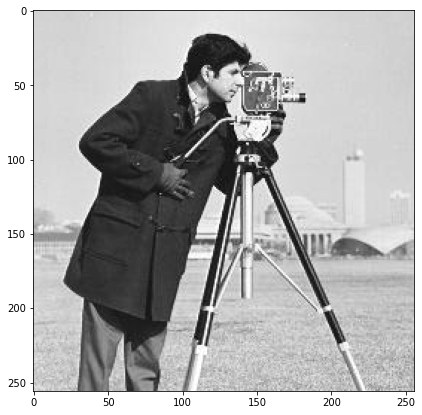

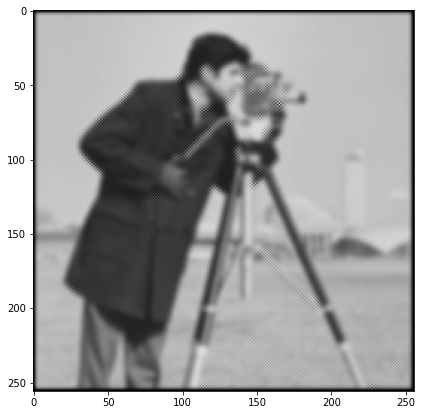

In [175]:
img = cv2.imread("img/cameraman.jpg", 0)
N=10
U = HeatEQ(img, c=0.3, N=N, dt=1, dx=1, dy=1)

for i in range(0, N, int(N/2)):
    plt.figure(figsize=(7,7))
    plt.imshow(U[i], cmap="gray")
    plt.show()

In [4]:
def HeatEQOptimized(img, c, N, dt, dx=1, dy=1):
    w, h = img.shape
    U = np.zeros((N, w, h))

    U[0] = img
    
    for n in range (1, N):
        cx = c * dt / dx**2
        cy = c * dt / dy**2
        x_term = np.roll(U[n - 1], -1, axis=0) - 2 * U[n - 1] + np.roll(U[n - 1], 1, axis=0)
        y_term = np.roll(U[n - 1], -1, axis=1) - 2 * U[n - 1] + np.roll(U[n - 1], 1, axis=1)
        U[n] = U[n - 1] + (cx * x_term + cy * y_term)
    return U

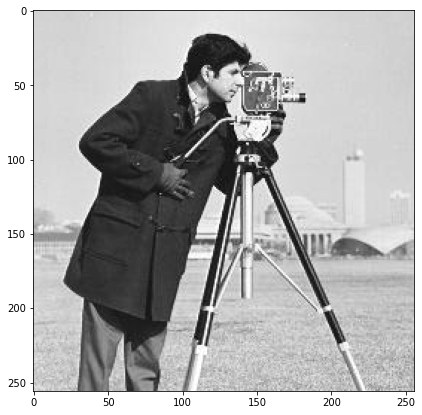

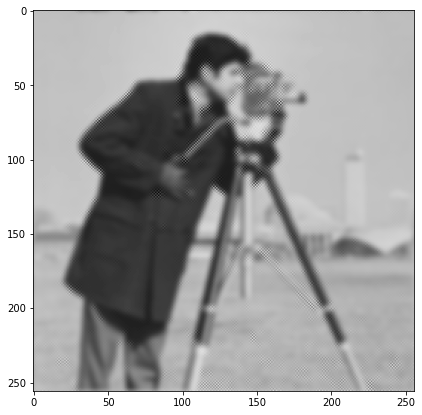

In [5]:
img = cv2.imread("img/cameraman.jpg", 0)
N=10
Uop = HeatEQOptimized(img, c=0.3, N=N, dt=1, dx=1, dy=1)

for i in range(0, N, int(N/2)):
    plt.figure(figsize=(7,7))
    plt.imshow(Uop[i], cmap="gray")
    plt.show()

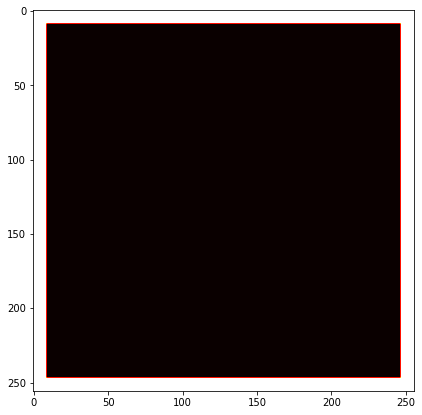

In [6]:
plt.figure(figsize=(7,7))

plt.imshow((np.abs(Uop[-1] - U[-1])) > 10e-8, cmap="hot")

**We can see that the optimized method using "np.roll" isn't affected much by the borders. And the difference between both methods is only located around these borders.**

### **2. The Perona-Malik scheme**

In [2]:
from scipy import ndimage
def tukey(x, k):
    return np.exp(-(x / k)**2)

# def lorentz(x, k, alpha=0.6):
#     return 1 / (1 + np.power(x / k, 1 + alpha))

def lorentz(x, k):
    return 1/(1+(x/k)**2)

def perona_malik(img, N=100, dt=0.2, g=lorentz, K=20):
    h, w = img.shape
    U = np.zeros((N, h, w))
    U[0] = img
    
    for n in range (1, N):       
        LN = np.roll(U[n - 1], -1, axis=0) - U[n - 1]
        LS = np.roll(U[n - 1],  1, axis=0) - U[n - 1]
        LE = np.roll(U[n - 1],  1, axis=1) - U[n - 1]
        LW = np.roll(U[n - 1], -1, axis=1) - U[n - 1]

        U[n] = U[n - 1] + dt * (g(LN, K) * LN + g(LW, K) * LW + g(LE,K) * LE + g(LS,K) * LS) 

    return U

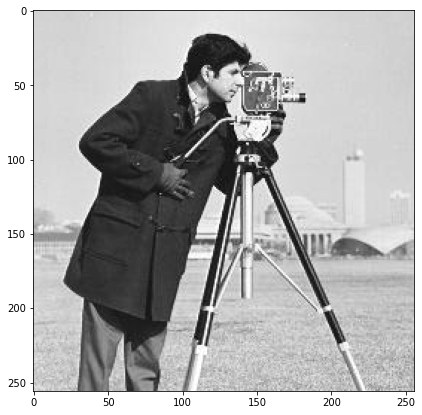

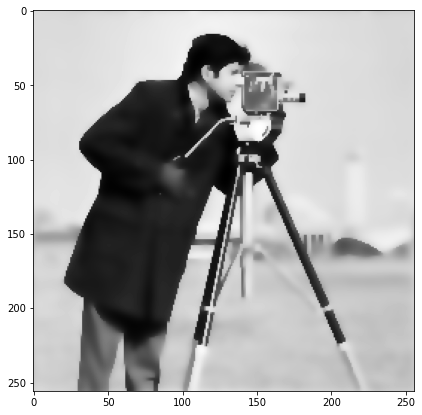

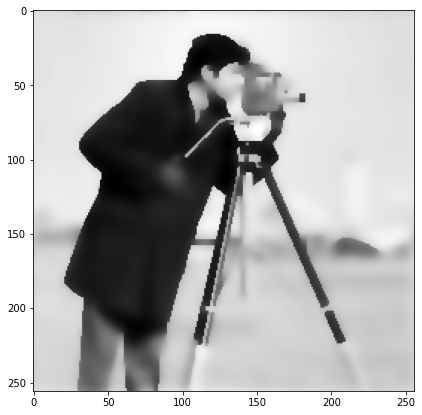

In [179]:
img = cv2.imread("../practical-work/img/cameraman.jpg", 0)
U = perona_malik(img, N=100, dt=0.1)
for i in range(0, len(U), 49):
    plt.figure(figsize=(7,7))
    plt.imshow(U[i], cmap="gray")
    plt.show()

### **3. The Edge Enhancing scheme**

In [3]:
from scipy.ndimage import gaussian_filter

def edge_enhancing(img, N=100, dt=0.2, sigma=1, K=25):
    h, w = img.shape
    U = np.zeros((N, h, w))
    U[0] = img
    l2 = np.exp(((0.5)**2)/K**2)
    l1 = l2 / 5
    for n in range (1, N):  
        gx = gaussian_filter(U[n - 1], sigma)
        gy = gaussian_filter(U[n - 1], sigma)
        
        gnorm = np.hypot(gx, gy)
        
        #compute a,b and c
        a = (l1 * gx**2 + l2 * gy**2) / (gnorm**2 + 10e-6)
        c = (l2 * gx**2 + l1 * gy**2) / (gnorm**2 + 10e-6)
        b = ((l1 - l2) * gx * gy)     / (gnorm**2 + 10e-6)
        
        """
        |----------.---------.----------|
        |(i-1,j+1) | (i,j+1) | (i+1,j+1)|
        |----------.---------.----------|
        | (i-1,j)  |  (i,j)  |  (i+1,j) |
        |----------.---------.----------|
        |(i-1,j-1) | (i,j-1) | (i+1,j-1)|
        |-------------------------------|
        """
        
        LNW = ((np.roll(b, -1, axis=0) + np.roll(b,  1, axis=1)) / 4) * np.roll(np.roll(U[n - 1], -1, axis=0),  1, axis=1)
        LN  = ((np.roll(c,  1, axis=1) + c)                      / 2) * np.roll(U[n - 1],  1, axis=1)
        LNE = ((np.roll(b,  1, axis=0) + np.roll(b,  1, axis=1)) / 4) * np.roll(np.roll(U[n - 1],  1, axis=0),  1, axis=1)
        LW  = ((np.roll(a, -1, axis=0) + a)                      / 2) * np.roll(U[n - 1], -1, axis=0)
        L   = ((np.roll(a,  -1, axis=0) + 2 * a + np.roll(a, 1, axis=0) + 
               (np.roll(c,  -1, axis=1) + 2 * c + np.roll(c, 1, axis=1))) / 2) * U[n - 1]
        LE  = ((np.roll(a,  1, axis=0) + a) / 2) * np.roll(U[n - 1],  1, axis=0)
        LSW = ((np.roll(b,  1, axis=0) + np.roll(b, -1, axis=1)) / 4) * np.roll(np.roll(U[n - 1], -1, axis=0), -1, axis=1)
        LS  = ((np.roll(c, -1, axis=1) + c)                      / 2) * np.roll(U[n - 1], -1, axis=1)
        LSE = ((np.roll(b,  1, axis=0) + np.roll(b, -1, axis=1)) / 4) * np.roll(np.roll(U[n - 1],  1, axis=0),  1, axis=1)
        

        U[n] = U[n - 1] + dt * ((-LNW + LN + LNE) +
                                ( LW  - L  + LE ) +
                                ( LSW + LS - LSE ))

    return U

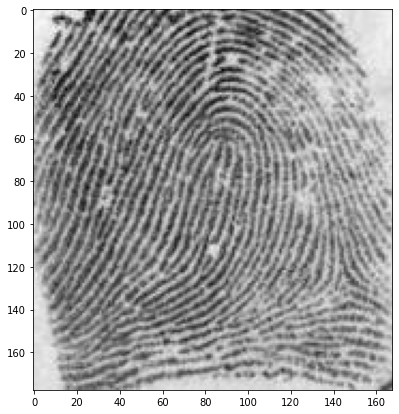

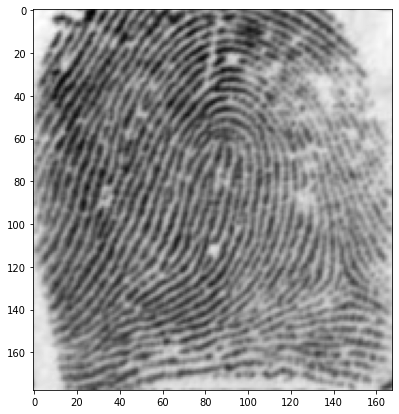

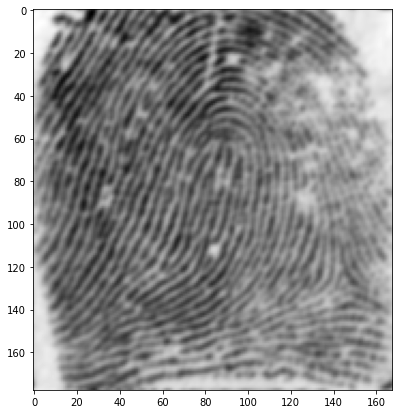

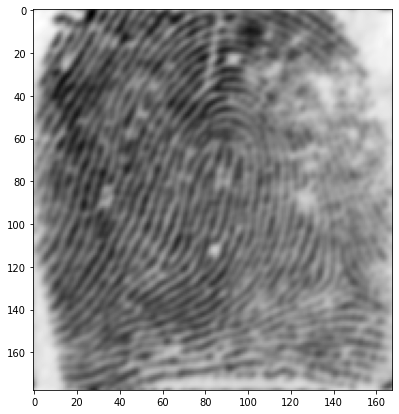

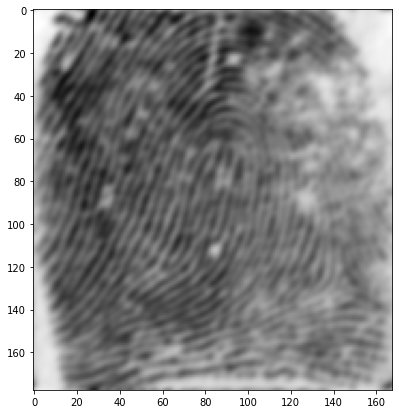

In [181]:
img = cv2.imread("../practical-work/img/fingerprint-small.jpg", 0)
U = edge_enhancing(img, N=25, dt=0.1, sigma=0.3, K=20)
for i in range(0, len(U), 5):
    plt.figure(figsize=(7,7))
    plt.imshow(U[i], cmap="gray")
    plt.show()

### **4. The 2-D heat equation using an implicit scheme**

In [107]:
from scipy.sparse import csc_matrix, csr_matrix, dia_matrix
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.sparse import diags, kron, eye
from scipy.sparse import block_diag

def HeatEQImplicit(img, N=100, c=0.4, dt=0.5, dx=1):
    alpha = c * dt / dx**2
    beta = alpha
    gamma = 1 + 2 * alpha + 2 * beta
    w, h = img.shape
    U = np.zeros((N, h, w))
    U[0] = img
    
    base = np.ones(img.shape)
    d_beta = -beta * base.flatten()
    d_alpha = -alpha * base.flatten()
    d_gamma = gamma * base.flatten()

    L = base.shape[0] * base.shape[1]
    Lb = base.shape[0]

    Aa = sparse.spdiags([d_alpha, d_alpha], [-base.shape[0], base.shape[0]], L, L,format='csr')
    Ab = sparse.spdiags([d_beta, d_gamma, d_beta], [-1,0,1], Lb, Lb,format='csr')
    
    #Aa = dia_matrix(([d_alpha, d_alpha], [-Lb, Lb]), shape=(L, L))
    #Ab = dia_matrix(([d_beta[:Lb], d_gamma[:Lb], d_beta[:Lb]], [-1,0,1]), shape=(Lb, Lb))
    
    A_tmp = kron(eye(Aa.shape[0] / Ab.shape[0]), Ab)

    A = A_tmp + Aa
       
    for n in range(1, N):
        Un = U[n - 1].flatten()  
        U[n] = spsolve(A, Un).reshape((h,w))
    return U

In [7]:
img = cv2.imread("img/cameraman.jpg", 0)

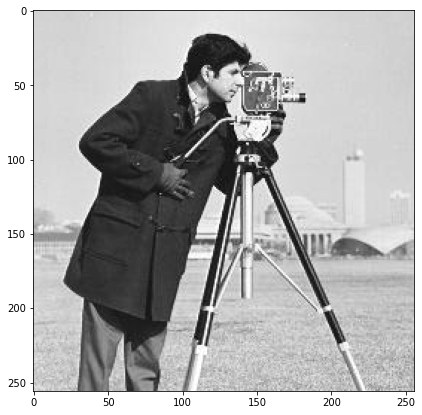

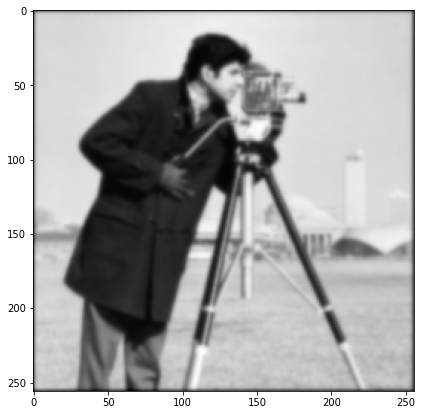

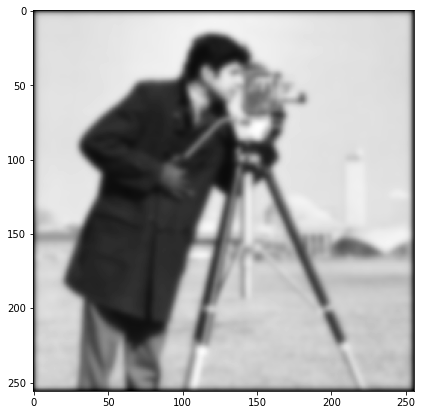

In [184]:
U = HeatEQImplicit(img, N=10, c=0.3, dt=1, dx=1)

for i in range(0, len(U), int(len(U)/ 2) - 1):
    plt.figure(figsize=(7,7))
    plt.imshow(U[i], cmap="gray")
    plt.show()

# **Experimentation**

### **Defining a error functions to measure the performance of each methods and eventual irregularities**

In [4]:
def mse(img, compressed):
    err = np.sum((img.astype("float") - compressed.astype("float")) ** 2)
    err /= float(img.shape[0] * img.shape[1])
    return err

def PSNR(img, compressed):
    mse_val = mse(img, compressed)
    if(mse_val == 0):
        return 100
    psnr = 20 * np.log10(np.max(img) / np.sqrt(mse_val))
    return psnr

### **Experimenting with the Explicit Heat Equation Scheme**

In [180]:
from tqdm import tqdm
img = cv2.imread("img/cameraman.jpg", 0)

dt = 1
dx = 1
dy = dx
N = 25
cN = 20
c_values = np.linspace(0,1, cN)

cbar = tqdm(c_values)
errors = []
Uu = []
for c in cbar:
    U = HeatEQ(img, c, N, dt, dx, dy)
    Uu.append(U)
    Uerrors = []
    for u in range(len(U)):
        cbar.set_postfix({'inner': u})
        Uerrors.append(mse(img, U[u]))
    errors.append(Uerrors)
errs = np.array(errors).reshape(cN, N)

100%|█████████████████████████████████| 20/20 [02:09<00:00,  6.50s/it, inner=24]


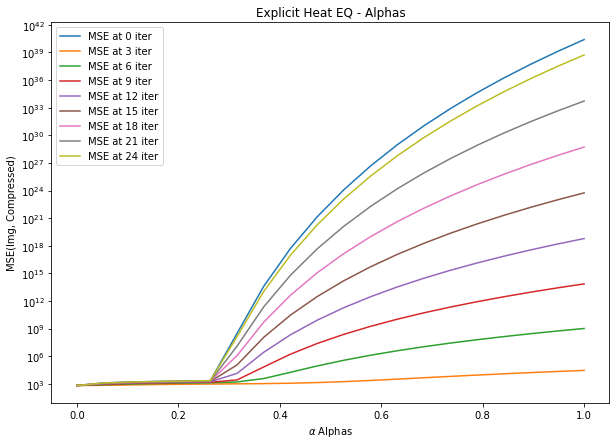

In [275]:
X = c_values
plt.figure(figsize=(10,7))
for i in range(0, N, 3):
    iterN = i
    plt.plot(X,errs[:, iterN - 1], label="MSE at {} iter".format(iterN))
    plt.legend()
    plt.xlabel(r"$\alpha$ Alphas")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Explicit Heat EQ - Alphas")
plt.show()

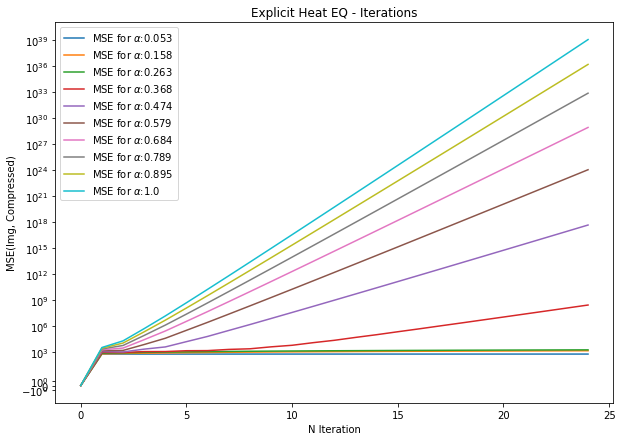

In [274]:
X = np.arange(N)
plt.figure(figsize=(10,7))
for c in range(1, cN, 2):
    iterN = c
    plt.plot(X, errs[iterN - 1, :], label=r"MSE for $\alpha$:{}".format(round(c_values[c], 3)))
    plt.legend()
    plt.xlabel("N Iteration")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Explicit Heat EQ - Iterations")
plt.show()

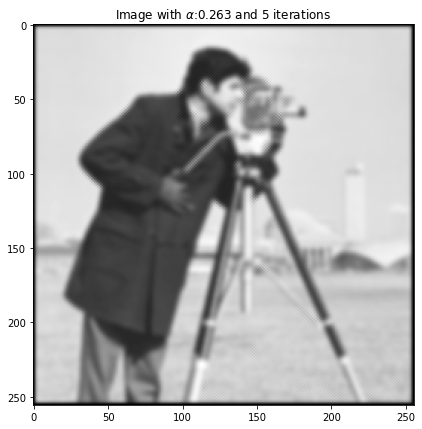

In [251]:
plt.figure(figsize=(10,7))
c = 5
N = 5
plt.title(r"Image with $\alpha$:{} and {} iterations".format(round(c_values[c], 3), N))
plt.imshow(Uu[c][N], cmap="gray")

### **Experimenting with Implicit Heat Equation**

In [262]:
dt = 1
dx = 1
dy = dx
N = 25
cN = 20
c_values = np.linspace(0,1, cN)

cbar = tqdm(c_values)
errors2 = []
Uu2 = []

for c in cbar:
    U = HeatEQImplicit(img, N, c, dt, dx)
    Uu2.append(U)
    Uerrors = []
    for u in range(len(U)):
        cbar.set_postfix({'inner': u})
        Uerrors.append(mse(img, U[u]))
    errors2.append(Uerrors)
errs2 = np.array(errors2).reshape(cN, N)

100%|█████████████████████████████████| 20/20 [08:27<00:00, 25.39s/it, inner=24]


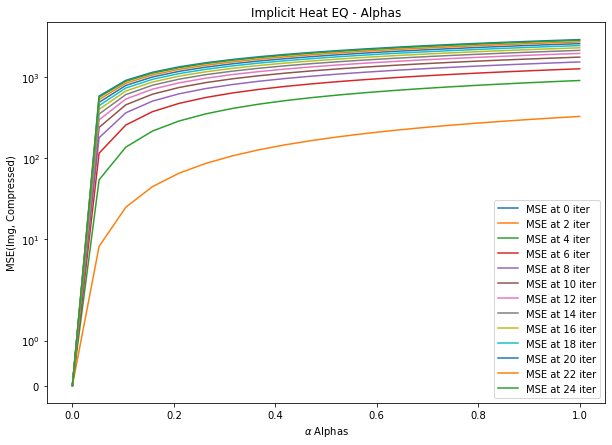

In [282]:
X = c_values
plt.figure(figsize=(10,7))
for i in range(0, N, 2):
    iterN = i
    plt.plot(X,errs2[:, iterN - 1], label="MSE at {} iter".format(iterN))
    plt.legend()
    plt.xlabel(r"$\alpha$ Alphas")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Implicit Heat EQ - Alphas")
plt.show()

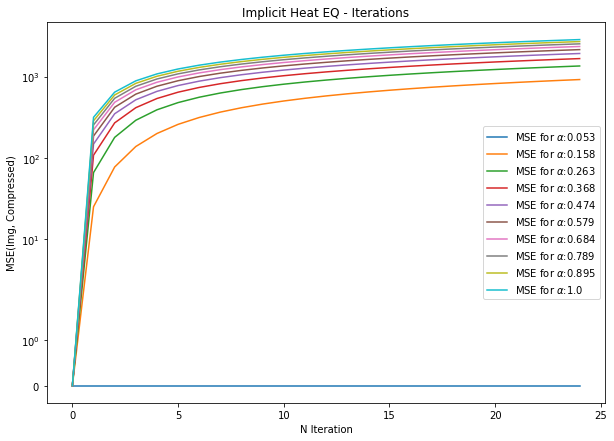

In [283]:
X = np.arange(N)
plt.figure(figsize=(10,7))
for c in range(1, cN, 2):
    iterN = c
    plt.plot(X, errs2[iterN - 1, :], label=r"MSE for $\alpha$:{}".format(round(c_values[c], 3)))
    plt.legend()
    plt.xlabel("N Iteration")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Implicit Heat EQ - Iterations")
plt.show()

In [180]:
plt.figure(figsize=(10,7))
c = 10
N = 5
plt.title(r"Image with $\alpha$:{} and {} iterations".format(round(c_values[c], 3), N))
plt.imshow(Uu2[c][N - 1], cmap="gray")

### Experimenting with the Perona-Malik Scheme

In [22]:
from tqdm import tqdm
dt = 1
dx = 1
dy = dx
N = 25
tN = 100
t_values = np.arange(1, tN + 1)

tbar = tqdm(t_values)
errors3t = []
Uut = []
for t in t_values:
    #U = HeatEQImplicit(img, N, c, dt, dx)
    U = perona_malik(img, N, dt=0.25, g=lorentz, K=t)
    Uut.append(U)
    Uerrors = []
    for u in range(len(U)):
        #tbar.set_postfix({'inner': t})
        Uerrors.append(mse(img, U[u]))
    errors3t.append(Uerrors)
errs3t = np.array(errors3t).reshape(tN, N)

  0%|                                                   | 0/100 [00:38<?, ?it/s]


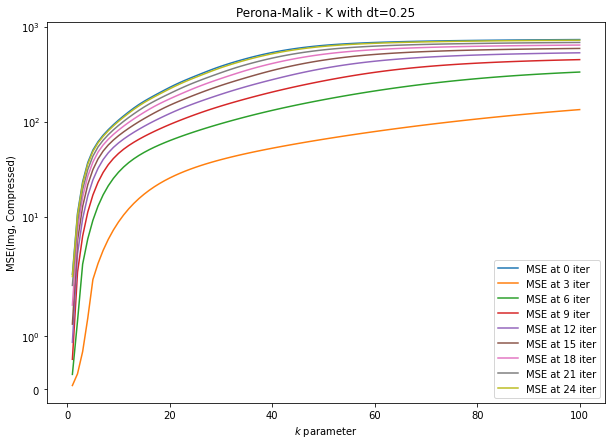

In [28]:
X = t_values
plt.figure(figsize=(10,7))
for i in range(0, N, 3):
    iterN = i
    plt.plot(X, errs3t[:, iterN - 1], label="MSE at {} iter".format(iterN))
    plt.legend()
    plt.xlabel(r"$k$ parameter")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title(r"Perona-Malik - K with dt={}".format(0.25))
plt.show()

In [29]:
plt.figure(figsize=(10,7))
t = 100
N = 25
plt.title(r"Image with $dt$:{} and {} iterations".format(round(t_values[t], 3), N))
plt.imshow(Uut[t][N - 1], cmap="gray")

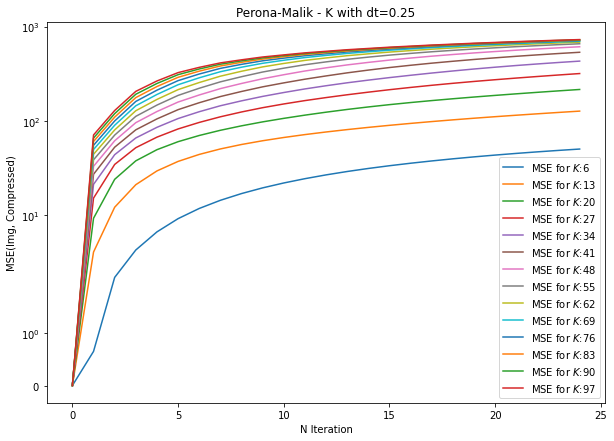

In [39]:
X = np.arange(N)
plt.figure(figsize=(10,7))

for t in range(5, tN, 7):
    iterN = t
    plt.plot(X, errs3t[iterN - 1, :], label=r"MSE for $K$:{}".format(round(t_values[t], 3)))
    plt.legend()
    plt.xlabel("N Iteration")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Perona-Malik - K with dt={}".format(0.25))
plt.show()

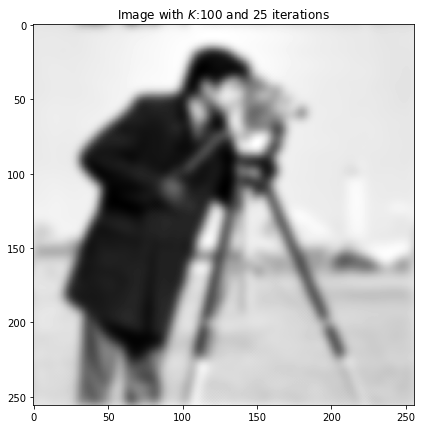

In [63]:
plt.figure(figsize=(10,7))
c = 99
N = 25
plt.title(r"Image with $K$:{} and {} iterations".format(round(t_values[c], 3), N))
plt.imshow(Uut[c][N - 1], cmap="gray")

### Experimenting with the Edge-Enhancing Scheme

In [77]:
img = cv2.imread("img/fingerprint-small.jpg", 0)

In [131]:
from tqdm import tqdm
dt = 1
dx = 1
dy = dx
N = 25
sN = 15
#s_values = np.arange(1, sN + 1)
#s_values = np.arange(1, sN + 1)
s_values = np.arange(1, sN + 1)

errors3s = []
Uus = []
for s in s_values:
    U = edge_enhancing(img, N=N, dt=0.5, sigma=0.3, K=int(s))
    Uus.append(U)
    Uerrors = []
    for u in range(len(U)):
        #tbar.set_postfix({'inner': t})
        Uerrors.append(mse(img, U[u]))
    errors3s.append(Uerrors)
errs3s = np.array(errors3s).reshape(sN, N)

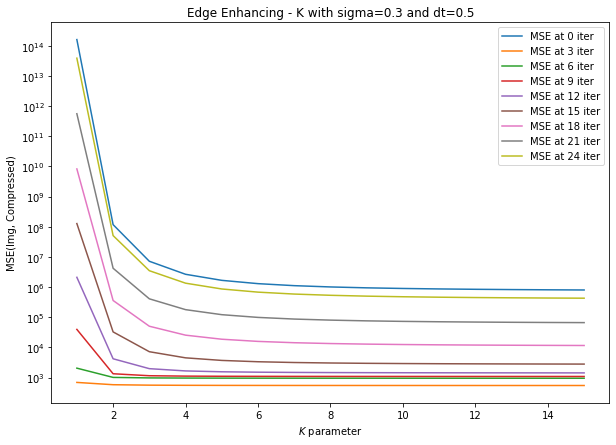

In [134]:
X = s_values
plt.figure(figsize=(10,7))
for i in range(0, N, 3):
    iterN = i
    plt.plot(X,errs3s[:, iterN - 1], label="MSE at {} iter".format(iterN))
    plt.legend()
    plt.xlabel(r"$K$ parameter")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Edge Enhancing - K with sigma=0.3 and dt=0.5")
plt.show()

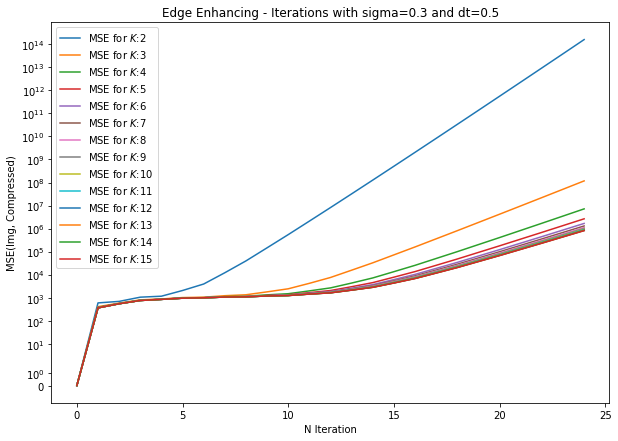

In [137]:
X = np.arange(N)
plt.figure(figsize=(10,7))

for t in range(1, sN, 1):
    iterN = t
    plt.plot(X, errs3s[iterN - 1, :], label=r"MSE for $K$:{}".format(round(s_values[t], 3)))
    plt.legend()
    plt.xlabel("N Iteration")
    plt.ylabel("MSE(Img, Compressed)")
    plt.yscale("symlog")
plt.title("Edge Enhancing - Iterations with sigma=0.3 and dt=0.5")
plt.show()

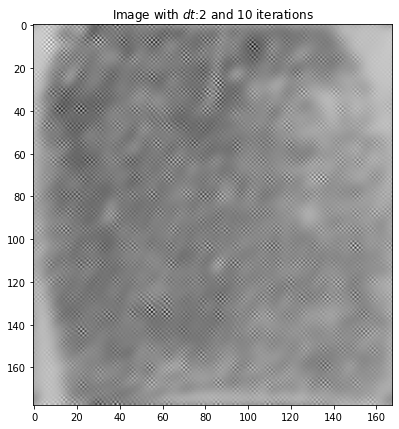

In [178]:
plt.figure(figsize=(10,7))
s = 1
N = 10
plt.title(r"Image with $dt$:{} and {} iterations".format(round(s_values[s], 3), N))
plt.imshow(Uus[s][N - 1], cmap="gray")